# 02. Vector Field Inference with Snapshot Data

This notebook introduces the basic usage of pyGOT for snapshot data. The example data is dentategyrus dataset from scvelo.datasets api. 

In [1]:
import scanpy as sc
import scvelo as scv
import pygot
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

## Helper function

In [2]:
## This function is from UniTVelo to evaluate the consistent between fitted velocity and groundtruth

def keep_type(adata, nodes, target, k_cluster):
    """Select cells of targeted type
    
    Args:
        adata (Anndata): 
            Anndata object.
        nodes (list): 
            Indexes for cells
        target (str): 
            Cluster name.
        k_cluster (str): 
            Cluster key in adata.obs dataframe

    Returns:
        list: 
            Selected cells.

    """
    return nodes[adata.obs[k_cluster][nodes].values == target]

def cross_boundary_correctness(
    adata, 
    k_cluster, 
    k_velocity, 
    cluster_edges, 
    return_raw=False, 
    x_emb="X_umap"
):
    """Cross-Boundary Direction Correctness Score (A->B)
    
    Args:
        adata (Anndata): 
            Anndata object.
        k_cluster (str): 
            key to the cluster column in adata.obs DataFrame.
        k_velocity (str): 
            key to the velocity matrix in adata.obsm.
        cluster_edges (list of tuples("A", "B")): 
            pairs of clusters has transition direction A->B
        return_raw (bool): 
            return aggregated or raw scores.
        x_emb (str): 
            key to x embedding for visualization.
        
    Returns:
        dict: 
            all_scores indexed by cluster_edges or mean scores indexed by cluster_edges
        float: 
            averaged score over all cells.
        
    """
    scores = {}
    all_scores = {}
    
    
    if x_emb == "X_umap":
        v_emb = adata.obsm['{}_umap'.format(k_velocity)]
    else:
        v_emb = adata.obsm[[key for key in adata.obsm if key.startswith(k_velocity)][0]]
    
    x_emb = adata.obsm[x_emb]

    for u, v in cluster_edges:
        sel = adata.obs[k_cluster] == u
        nbs = adata.uns['neighbors']['indices'][sel] # [n * 30]
        
        boundary_nodes = map(lambda nodes:keep_type(adata, nodes, v, k_cluster), nbs)
        x_points = x_emb[sel]
        x_velocities = v_emb[sel]
        
        type_score = []
        for x_pos, x_vel, nodes in zip(x_points, x_velocities, boundary_nodes):
            if len(nodes) == 0: continue

            position_dif = x_emb[nodes] - x_pos
            dir_scores = cosine_similarity(position_dif, x_vel.reshape(1,-1)).flatten()
            type_score.append(np.mean(dir_scores))
        
        scores[(u, v)] = np.mean(type_score)
        all_scores[(u, v)] = type_score
        
    if return_raw:
        return all_scores 
    
    return scores, np.mean([sc for sc in scores.values()])

In [3]:

def calculate_cluster_centres(data, cluster_labels):
    
    
    unique_labels = np.unique(cluster_labels)
    
    cluster_centres = {}
    
    for label in unique_labels:
        cluster_points = data[cluster_labels == label]
        
        cluster_centre = cluster_points.mean(axis=0)
        cluster_centres[label] = cluster_centre
    
    return cluster_centres

def plot_mst(adata, mst_children, cell_type_key,  basis='umap'):
        data = adata.obsm['X_' + basis]
        cluster_labels = adata.obs[cell_type_key].to_numpy()
        cluster_centres = calculate_cluster_centres(data, cluster_labels)
       
        fig, ax = plt.subplots(1, 1, )
        
        sc.pl.embedding(adata, color=cell_type_key, legend_loc='on data', basis=basis, ax=ax, show=False,)
        start_node_indicator = {i : True for i in mst_children }
        
        
        for root, kids in mst_children.items():
            for child in kids:
                start_node_indicator[child] = False
                x_coords = [cluster_centres[root][0], cluster_centres[child][0]]
                y_coords = [cluster_centres[root][1], cluster_centres[child][1]]
                ax.plot(x_coords, y_coords, 'k-')
                ax.arrow(x_coords[-2], y_coords[-2], x_coords[-1] - x_coords[-2], y_coords[-1] -  y_coords[-2], head_width=1.0, fc='red', ec='red', length_includes_head=True,)

        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title('Manual annotation of cell dynamics')
        
        plt.show()

## Import data and preprocess

In [4]:

adata = scv.datasets.dentategyrus_lamanno('../../../../data/DentateGyrus/DentateGyrus.loom')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

embedding_key = 'X_pca' # Use pca as latent space
cell_type_key = 'clusters'
vis_key = 'tsne'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 2000 highly variable genes.
Logarithmized X.


/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(values):


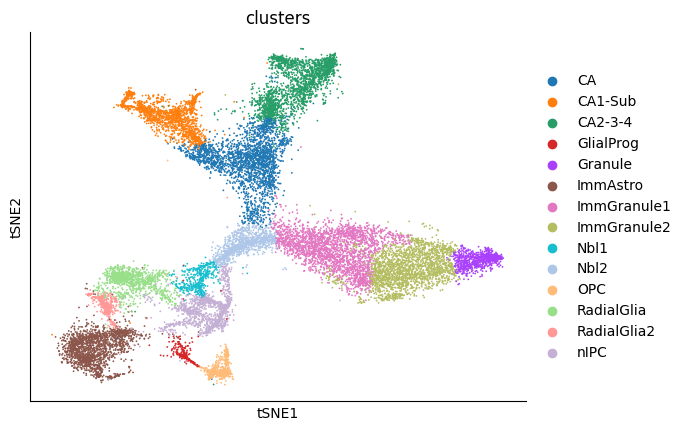

In [5]:
sc.pl.tsne(adata, color=cell_type_key)

According to [La Manno et al. (2018)](https://www.nature.com/articles/s41586-018-0414-6), the source cell type of this dataset should be `nIPC` cell type. And the groundtruth of cell type transition is as

[('nIPC', 'GlialProg'), ('Nbl1', 'Nbl2'), ('Nbl2', 'CA'), ('Nbl2', 'ImmGranule1'), ('ImmGranule1', 'ImmGranule2'), ('ImmGranule2', 'Granule'), ('CA', 'CA1-Sub'), ('CA', 'CA2-3-4'), ('RadialGlia', 'RadialGlia2'), ('RadialGlia2', 'ImmAstro'), ('GlialProg', 'OPC')]


/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/ruihong/anaconda3/envs/got/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(values):


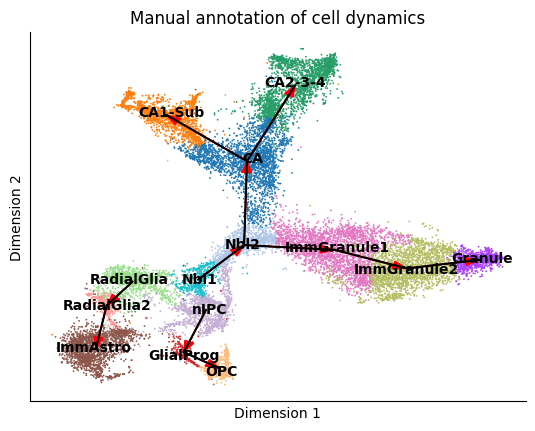

In [6]:
tree = {
    'nIPC':['GlialProg'],
    'Nbl1':['Nbl2'],
    'Nbl2':['CA','ImmGranule1'],
    'ImmGranule1':['ImmGranule2'],
    'ImmGranule2':['Granule'],
    'CA': [ 'CA1-Sub', 'CA2-3-4'],
    'RadialGlia':['RadialGlia2'],
    'RadialGlia2':['ImmAstro'],
    'GlialProg':['OPC'],
}
edges = []
for key in tree:
    for target in tree[key]:
        edges.append((key, target))
print(edges)
plot_mst(adata, tree, cell_type_key='clusters',  basis='tsne')

## scvelo stochastic mode

In [7]:
warnings.filterwarnings('ignore')
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)


computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


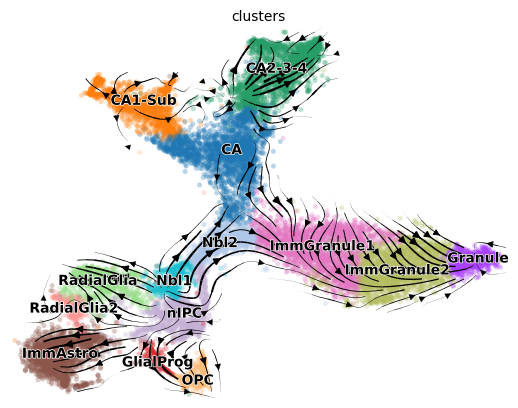

In [8]:
scv.pl.velocity_embedding_stream(adata, color=cell_type_key, basis='tsne')

The velocity stream plot from scvelo stochastic mode is partial consistent with groudtruth. Compute the `cross_boundary_correctness` between predicted results and given groudtruth

In [9]:
_, cbc_scvelo_stochastic = cross_boundary_correctness(adata, cell_type_key, 'velocity_'+vis_key, edges, False, 'X_'+vis_key)
print(cbc_scvelo_stochastic)

0.322421113443348


## scvelo dynamical mode

In [10]:
warnings.filterwarnings('ignore')
scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 10/10 cores)
    finished (0:04:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


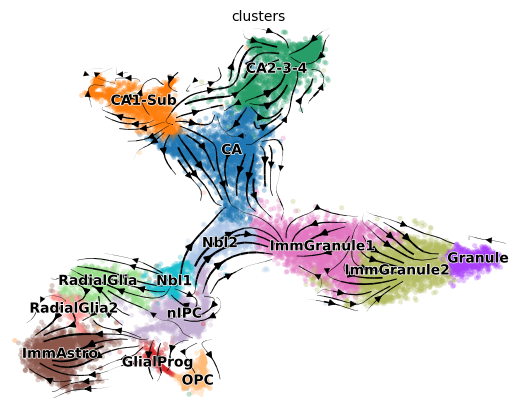

In [11]:
warnings.filterwarnings('ignore')
scv.pl.velocity_embedding_stream(adata, color=cell_type_key, basis='tsne')

The velocity stream plot from scvelo dynamical mode is not better than stochastic mode. Compute the `cross_boundary_correctness`

In [12]:
_, cbc_scvelo_dynamical = cross_boundary_correctness(adata, cell_type_key, 'velocity_'+vis_key, edges, False, 'X_'+vis_key)
print(cbc_scvelo_dynamical)

0.14824180758851663


## GOT to identify source cell

Here, we use got to identify source cell based on the optimal transport metrics. The assumption is that the transition cost from source cell to all cell distribution is smallest than any other developing cell. By default, to accelerate computational speed, we down-sampling dataset. The result is very similar if the number of cells in down-sampling dataset large than 3000.

In [13]:
pygot.tl.traj.determine_source_state(adata, embedding_key=embedding_key)

Down sampling


100%|██████████| 3000/3000 [06:00<00:00,  8.33it/s]


optimal transport root cell write in adata.uns['ot_root']
optimal transport + cytotrace root cell write in adata.uns['ot_ct_root']


,cell,raw_root_loss,idx,root_loss,root_score,ct_root_score
628,10X84_3:CCTAAAGTCCTGTAGAx,20.167403,628,20.305454,1.000000,0.890152
2099,10X83_3:CGGCTAGCAAACCTACx,20.023151,2099,20.320417,0.992036,0.882109
1009,10X83_3:TGCTACCCAATAACGAx,20.220465,1009,20.320417,0.992036,0.881782
2335,10X84_2:TGAGCCGTCTGGCGTGx,20.354053,2335,20.382536,0.958975,0.857346
341,10X84_2:CACTCCATCCCATTATx,20.253704,341,20.388701,0.955694,0.850167
...,...,...,...,...,...,...
818,10X83_2:AGGTCATGTCTCCCTAx,22.25202,818,22.111518,0.038774,0.063349
1298,10X83_3:CTGGTCTTCCTTGGTCx,22.121748,1298,22.118788,0.034905,0.058904
330,10X84_2:GACAGAGTCTGCTGCTx,22.145375,330,22.129215,0.029355,0.054419
1710,10X83_2:TCAGGTAAGGGTGTTGx,22.234469,1710,22.153983,0.016173,0.043674


Visulaize the `root_score`, which represents the probability of being source cell. The score of some `nIPC` and `Nbl1` cells are significantly higher than other cells. 

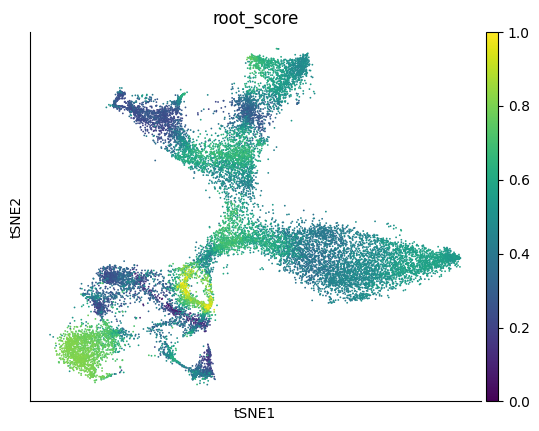

In [14]:
sc.pl.tsne(adata, color='root_score')

Further, we can visualize the most prossible source cell.

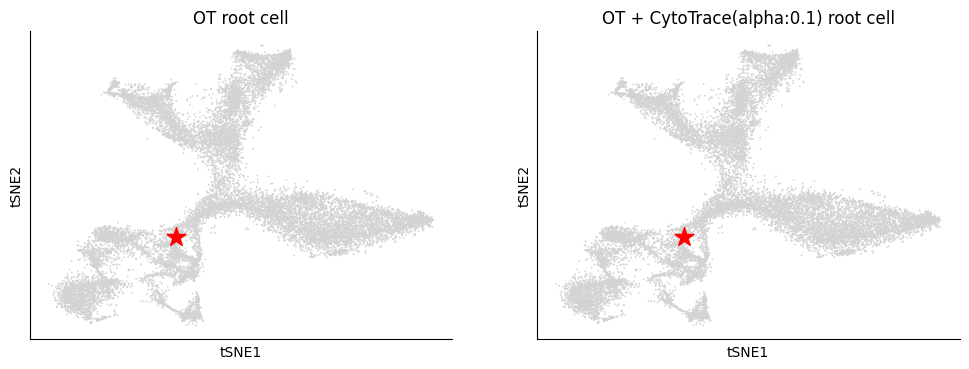

In [15]:
pygot.pl.plot_root_cell(adata, basis='tsne', figsize=(12,4))

Since the differentiation process is non-linear, we use the cell with optimal root_score value (OT root cell) as the source cell

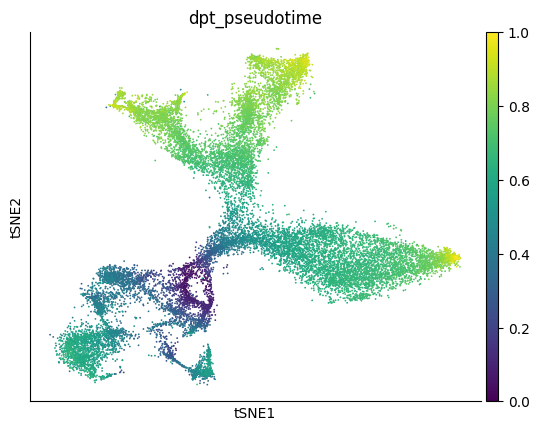

In [16]:
adata.uns['iroot'] = adata.uns['ot_root']
sc.tl.dpt(adata)
sc.pl.tsne(adata, color='dpt_pseudotime')

Based on the precomputed pseudotime, we can train a velocity model

In [17]:
model, history = pygot.tl.traj.fit_velocity_model_without_time(adata, embedding_key=embedding_key, 
                                                         precomputed_pseudotime='dpt_pseudotime', single_branch_detect=False)
                                                         


2025-05-05 16:49:49	 Start to fit velocity model
loading saved shortest path profile
[Errno 2] No such file or directory: '_0.0to1.0.pkl'
Error in loading shortest path file
calcu shortest path between 0.0 to 1.0


100%|██████████| 608/608 [00:00<00:00, 1617.27it/s]


calcu shortest path between 1.0 to 2.0


100%|██████████| 608/608 [00:00<00:00, 1677.85it/s]


calcu shortest path between 2.0 to 3.0


100%|██████████| 608/608 [00:00<00:00, 1702.06it/s]


calcu shortest path between 3.0 to 4.0


100%|██████████| 607/607 [00:00<00:00, 1923.36it/s]


calcu shortest path between 4.0 to 5.0


100%|██████████| 607/607 [00:00<00:00, 1726.92it/s]


calcu shortest path between 5.0 to 6.0


100%|██████████| 607/607 [00:00<00:00, 1891.79it/s]


calcu shortest path between 6.0 to 7.0


100%|██████████| 607/607 [00:00<00:00, 1926.11it/s]


calcu shortest path between 7.0 to 8.0


100%|██████████| 607/607 [00:00<00:00, 2253.62it/s]


calcu shortest path between 8.0 to 9.0


100%|██████████| 607/607 [00:00<00:00, 2617.74it/s]


calcu shortest path between 9.0 to 10.0


100%|██████████| 607/607 [00:00<00:00, 3654.07it/s]


calcu shortest path between 10.0 to 11.0


100%|██████████| 607/607 [00:00<00:00, 3102.92it/s]


calcu shortest path between 11.0 to 12.0


100%|██████████| 607/607 [00:00<00:00, 3406.26it/s]


calcu shortest path between 12.0 to 13.0


100%|██████████| 607/607 [00:00<00:00, 2468.46it/s]


calcu shortest path between 13.0 to 14.0


100%|██████████| 607/607 [00:00<00:00, 2096.73it/s]


calcu shortest path between 14.0 to 15.0


100%|██████████| 607/607 [00:00<00:00, 2034.51it/s]


calcu shortest path between 15.0 to 16.0


100%|██████████| 607/607 [00:00<00:00, 2046.50it/s]


calcu shortest path between 16.0 to 17.0


100%|██████████| 607/607 [00:00<00:00, 1764.39it/s]


calcu shortest path between 17.0 to 18.0


100%|██████████| 607/607 [00:00<00:00, 1797.81it/s]


calcu shortest path between 18.0 to 19.0


100%|██████████| 607/607 [00:00<00:00, 1895.33it/s]


calcu shortest path between 19.0 to 20.0


100%|██████████| 607/607 [00:00<00:00, 1764.13it/s]


calcu shortest path between 20.0 to 21.0


100%|██████████| 607/607 [00:00<00:00, 1724.92it/s]


calcu shortest path between 21.0 to 22.0


100%|██████████| 607/607 [00:00<00:00, 1766.57it/s]


calcu shortest path between 22.0 to 23.0


100%|██████████| 607/607 [00:00<00:00, 1868.78it/s]


calcu shortest path between 23.0 to 24.0


100%|██████████| 607/607 [00:00<00:00, 1795.18it/s]


calcu shortest path between 24.0 to 25.0


100%|██████████| 607/607 [00:00<00:00, 1690.22it/s]


calcu shortest path between 25.0 to 26.0


100%|██████████| 607/607 [00:00<00:00, 1729.11it/s]


calcu shortest path between 26.0 to 27.0


100%|██████████| 607/607 [00:00<00:00, 1803.91it/s]


calcu shortest path between 27.0 to 28.0


100%|██████████| 607/607 [00:00<00:00, 1713.52it/s]


calcu shortest path between 28.0 to 29.0


loss :1087.6276  best :1087.6276: 100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


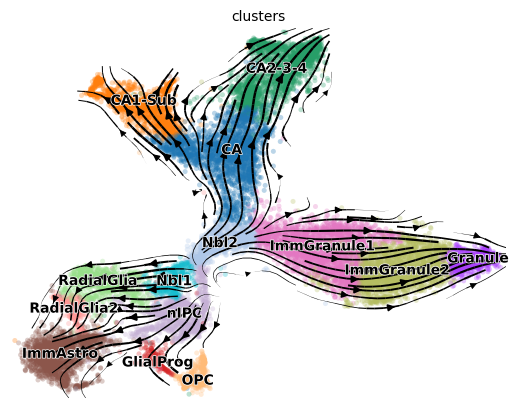

In [20]:
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model)
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key='velocity_pca')
scv.tl.velocity_embedding(adata, basis='tsne')
scv.pl.velocity_embedding_stream(adata, basis='tsne')

## GOT velocity fitting for snapshot data

The above process (including 1. source cell searching, 2. linear differentiation identification, 3. velocity model fitting) is integrated in one function of `pygot.tl.traj.fit_velocity_model_without_time`.

2025-05-05 16:55:13	 Using extrema in diffmap space to connect the whole graph
2025-05-05 16:55:14	 Search for the best source cell..
Down sampling
Convert into connected graph


100%|██████████| 3000/3000 [09:53<00:00,  5.06it/s]


optimal transport root cell write in adata.uns['ot_root']
optimal transport + cytotrace root cell write in adata.uns['ot_ct_root']
2025-05-05 17:05:15	 Determine linear progress or not..
2025-05-05 17:05:15	 Single Branch Progress : False


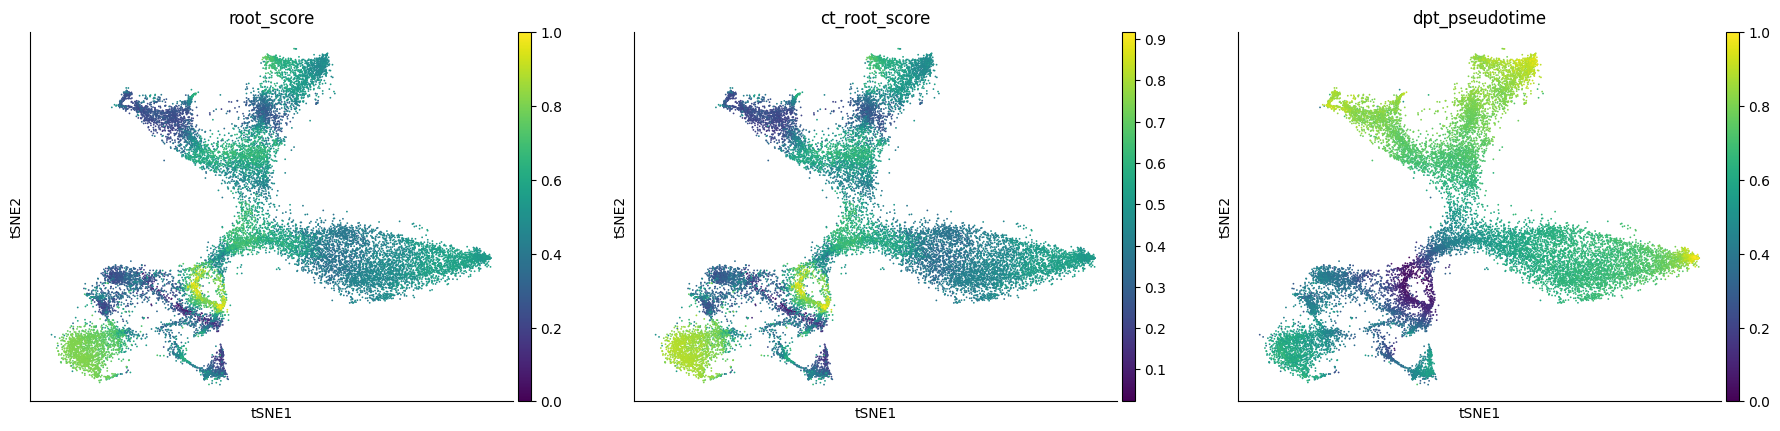

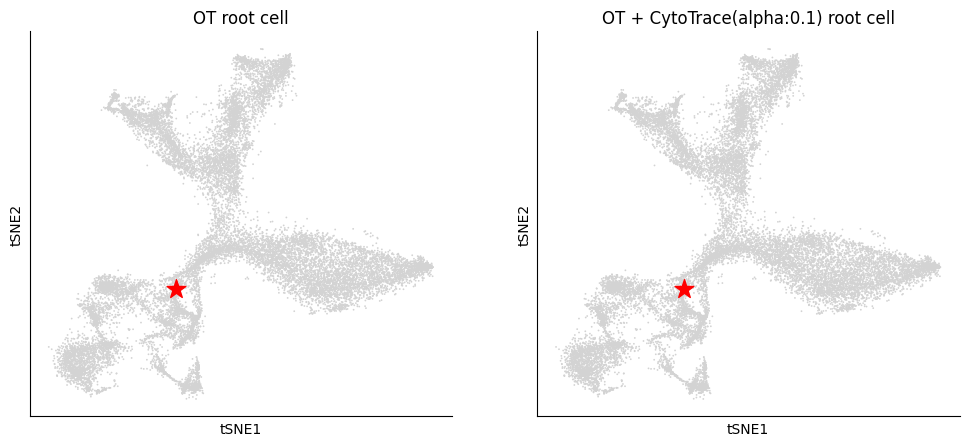

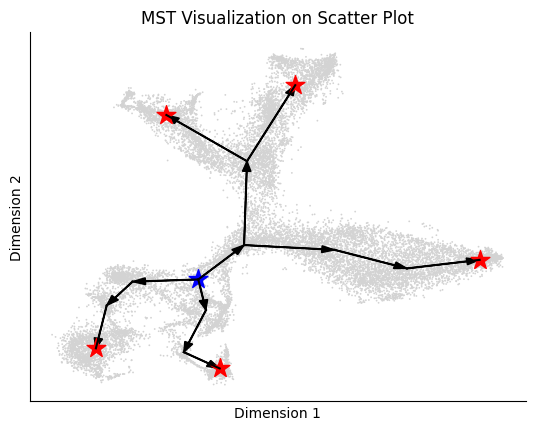

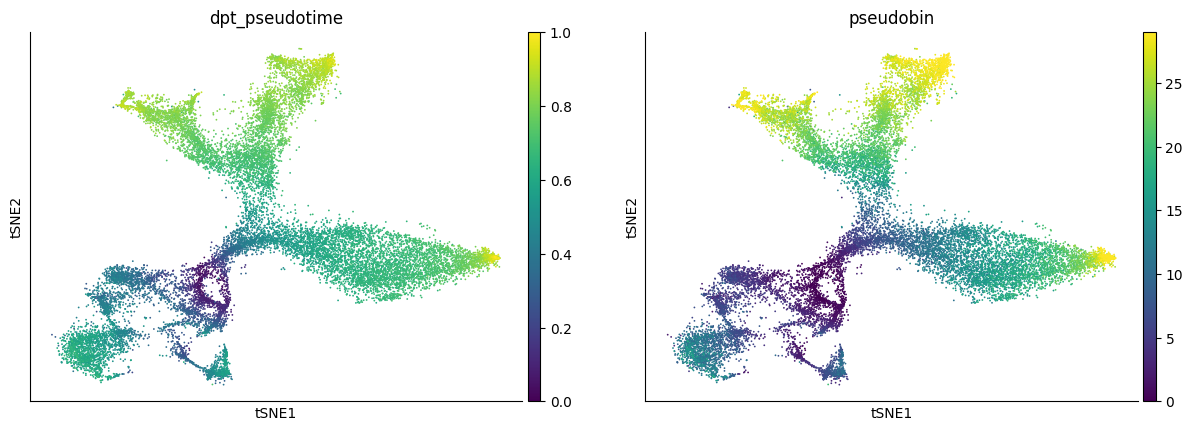

2025-05-05 17:05:16	 Start to fit velocity model
loading saved shortest path profile
[Errno 2] No such file or directory: '_0.0to1.0.pkl'
Error in loading shortest path file
calcu shortest path between 0.0 to 1.0


100%|██████████| 608/608 [00:00<00:00, 1465.87it/s]


calcu shortest path between 1.0 to 2.0


100%|██████████| 608/608 [00:00<00:00, 1514.16it/s]


calcu shortest path between 2.0 to 3.0


100%|██████████| 608/608 [00:00<00:00, 1578.37it/s]


calcu shortest path between 3.0 to 4.0


100%|██████████| 607/607 [00:00<00:00, 1610.52it/s]


calcu shortest path between 4.0 to 5.0


100%|██████████| 607/607 [00:00<00:00, 1675.58it/s]


calcu shortest path between 5.0 to 6.0


100%|██████████| 607/607 [00:00<00:00, 1305.68it/s]


calcu shortest path between 6.0 to 7.0


100%|██████████| 607/607 [00:00<00:00, 1691.25it/s]


calcu shortest path between 7.0 to 8.0


100%|██████████| 607/607 [00:00<00:00, 2119.60it/s]


calcu shortest path between 8.0 to 9.0


100%|██████████| 607/607 [00:00<00:00, 2140.69it/s]


calcu shortest path between 9.0 to 10.0


100%|██████████| 607/607 [00:00<00:00, 2694.50it/s]


calcu shortest path between 10.0 to 11.0


100%|██████████| 607/607 [00:00<00:00, 2402.51it/s]


calcu shortest path between 11.0 to 12.0


100%|██████████| 607/607 [00:00<00:00, 2259.17it/s]


calcu shortest path between 12.0 to 13.0


100%|██████████| 607/607 [00:00<00:00, 2119.57it/s]


calcu shortest path between 13.0 to 14.0


100%|██████████| 607/607 [00:00<00:00, 1930.26it/s]


calcu shortest path between 14.0 to 15.0


100%|██████████| 607/607 [00:00<00:00, 1776.88it/s]


calcu shortest path between 15.0 to 16.0


100%|██████████| 607/607 [00:00<00:00, 1797.09it/s]


calcu shortest path between 16.0 to 17.0


100%|██████████| 607/607 [00:00<00:00, 1596.81it/s]


calcu shortest path between 17.0 to 18.0


100%|██████████| 607/607 [00:00<00:00, 1674.69it/s]


calcu shortest path between 18.0 to 19.0


100%|██████████| 607/607 [00:00<00:00, 1694.12it/s]


calcu shortest path between 19.0 to 20.0


100%|██████████| 607/607 [00:00<00:00, 1540.37it/s]


calcu shortest path between 20.0 to 21.0


100%|██████████| 607/607 [00:00<00:00, 1681.04it/s]


calcu shortest path between 21.0 to 22.0


100%|██████████| 607/607 [00:00<00:00, 1564.89it/s]


calcu shortest path between 22.0 to 23.0


100%|██████████| 607/607 [00:00<00:00, 1686.72it/s]


calcu shortest path between 23.0 to 24.0


100%|██████████| 607/607 [00:00<00:00, 1617.16it/s]


calcu shortest path between 24.0 to 25.0


100%|██████████| 607/607 [00:00<00:00, 1467.67it/s]


calcu shortest path between 25.0 to 26.0


100%|██████████| 607/607 [00:00<00:00, 1371.40it/s]


calcu shortest path between 26.0 to 27.0


100%|██████████| 607/607 [00:00<00:00, 1491.24it/s]


calcu shortest path between 27.0 to 28.0


100%|██████████| 607/607 [00:00<00:00, 1344.80it/s]


calcu shortest path between 28.0 to 29.0


loss :1384.4429  best :1384.4429: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


In [21]:

warnings.filterwarnings('ignore')
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'
model, history = pygot.tl.traj.fit_velocity_model_without_time(adata, embedding_key, plot=True, basis='tsne', single_branch_detect=True, cell_type_key=cell_type_key)

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


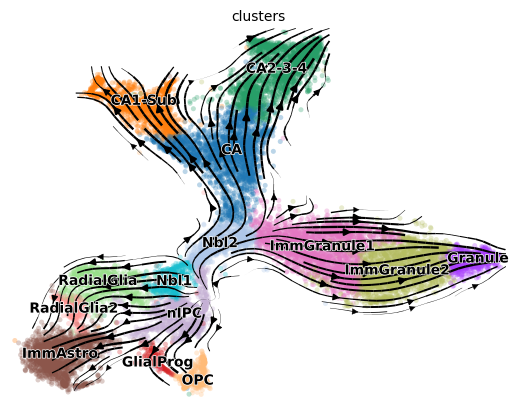

In [22]:
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model)
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key='velocity_pca')
scv.tl.velocity_embedding(adata, basis='tsne')
scv.pl.velocity_embedding_stream(adata, basis='tsne')

In [23]:
_, cbc_got = cross_boundary_correctness(adata, cell_type_key, 'velocity_'+vis_key, edges, False, 'X_'+vis_key)
print(cbc_got)

0.5980271152844634
